In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/finaldata/Final_PowerBI_input.xlsx


**BERT Notes :**

1. BERT is transformer based model which is different from LLSTM model in the sense,text doesnt have to put in a sequence in BERT compared to LSTM models.So it is fast as a whole sentence can be splitted into words and put at once i.e parallel processing of the words are possible.Even though the words are put at once,BERT has the ability to catch the sequence btw the words and the context in which it is being used in the sentence.This also solves one of the problem with the LSTM models where when the sentences become very long,there are chances of the LSTM model to loose the context and effect of one word on other words.This is solved in BERT model by assigning position to each of the words of the sentence before inserting into the attention layers and is achieved by the "positional encoding" layer.

2. BERT is also different from other DL models in the sense that it generates "contextual embeddings" i.e a word has different vector representation depending on the contect in which is used.This is lacked by the word2vec or glove models.

3. BERT is basically trained for two tasks : First for masked language modelling ( masking 15 % of the words in the corpus and then asking the NN to preddict those words ) and second for next sentence prediction ( given two sentences,predicte that if the next sentence is continuation/follow of the previous sentence.

4. BERT can be very easily fine tuned for the specifics NLP tasks like sentiment analysis,question answering etc.It has million of parameters,so even fine tunning the BERT model for 1-2 epochs enchanes the performace a lot.

5. BERT has a non-directional artitecture compared to bidirectional or single in LSTMs.

In [97]:
import pandas as pd
import transformers
import torch
from torch.utils import data
from torch import nn,optim
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score,matthews_corrcoef,confusion_matrix,classification_report
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [4]:
! pip install openpyxl nlpaug

     |████████████████████████████████| 243 kB 624 kB/s eta 0:00:01
     |████████████████████████████████| 405 kB 3.9 MB/s eta 0:00:01


In [5]:
df = pd.read_excel("../input/finaldata/Final_PowerBI_input.xlsx",usecols=["Rating","Main_Review","Pros","Cons","Sentiment","Review_id"],engine="openpyxl")
df.drop_duplicates(inplace=True)
df

,Rating,Pros,Cons,Main_Review,Review_id,Sentiment
0,4,NaN,NaN,1. This company has eight hours shift round th...,1,POSITIVE
2,4,NaN,NaN,"As with all jobs, your experience will depend ...",2,POSITIVE
5,5,Good benefits,Work your life away,Very hot and dirty working conditions very old...,3,NEUTRAL
7,5,"Full benefits, good pay, mist fans",The Texas heat,Everyone is pretty helpful there especially be...,4,POSITIVE
10,5,Benefits,Oil related,Rewarding place to work. Everyone is professio...,5,POSITIVE
...,...,...,...,...,...,...
21561,4,NaN,NaN,NaN,10884,POSITIVE
21562,1,NaN,NaN,NaN,10885,NEGATIVE
21563,4,NaN,NaN,NaN,10886,POSITIVE
21564,3,NaN,NaN,NaN,10887,POSITIVE


<AxesSubplot:>

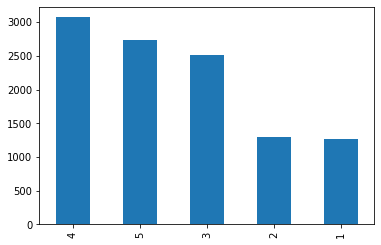

In [6]:
df.Rating.value_counts().plot(kind="bar")

**{0:"NEGATIVE",
   1:"NEUTRAL",
   2:"POSITIVE"}**

In [7]:
## For "Main_Review" column, assigning review based on "Rating' column

temp_df = df.copy()
temp_df["Actual_Sentiment"] = temp_df.loc[:,"Rating"].apply(lambda x : 0 if x <= 2 else 1 if x == 3 else 2)
temp_df["Review"] = temp_df["Main_Review"].str.replace(r"'|\"|\"|'|!|\s+", " ",regex=True)
temp_df.dropna(subset=["Review"],inplace=True)

temp_df = temp_df[["Review","Actual_Sentiment","Review_id"]]
temp_df

######################################################################
## Assigning POSITIVE sentiment to all the reviews in "Pros" category.

temp_df_1 = df.copy()
temp_df_1["Actual_Sentiment"] = 2
temp_df_1["Review"] = temp_df_1["Pros"].str.replace(r"'|\"|\"|'|!|\s+", " ",regex=True)
temp_df_1.dropna(subset=["Review"],inplace=True)

temp_df_pros = temp_df_1[["Review","Actual_Sentiment","Review_id"]]
temp_df_pros

######################################################################
## Assigning NEGATIVE sentiment to all the reviews in "Cons" category.

temp_df_2 = df.copy()
temp_df_2["Actual_Sentiment"] = 0
temp_df_2["Review"] = temp_df_2["Cons"].str.replace(r"'|\"|\"|'|!|\s+", " ",regex=True)
temp_df_2.dropna(subset=["Review"],inplace=True)

temp_df_cons = temp_df_2[["Review","Actual_Sentiment","Review_id"]]
temp_df_cons

######################################################################

final_df = pd.concat([temp_df,temp_df_pros,temp_df_cons],axis=0,ignore_index=True)
final_df.reset_index(inplace=True)
final_df

,index,Review,Actual_Sentiment,Review_id
0,0,1. This company has eight hours shift round th...,2,1
1,1,"As with all jobs, your experience will depend ...",2,2
2,2,Very hot and dirty working conditions very old...,2,3
3,3,Everyone is pretty helpful there especially be...,2,4
4,4,Rewarding place to work. Everyone is professio...,2,5
...,...,...,...,...
21688,21688,Not much of work at the start,0,10858
21689,21689,its a captive company but work wise worst then...,0,10859
21690,21690,None whatsoever,0,10860
21691,21691,Poor management,0,10862


<AxesSubplot:ylabel='Frequency'>

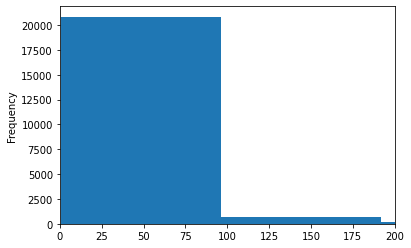

In [8]:
final_df["Review_len"] = final_df["Review"].apply(lambda x : len(x.split()))
final_df["Review_len"].plot(kind="hist",xlim=(0,200))

# This shows that most of the reviews have less than 100 words in it .

In [9]:
# Dropping data that has only one word in review

drop_index = final_df.query('Review_len <=1').index

final_df = final_df.loc[~final_df.index.isin(drop_index) , :]

final_df.shape

(20808, 5)

2    10647
0     8714
1     1447
Name: Actual_Sentiment, dtype: int64


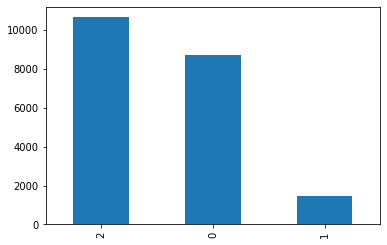

In [10]:
final_df["Actual_Sentiment"].value_counts().plot(kind="bar")

print(final_df["Actual_Sentiment"].value_counts())

# Neutral sentiment is very less, so need to perform text augmentation 

In [11]:
final_df.loc[final_df["Review_id"]==4,:]

,index,Review,Actual_Sentiment,Review_id,Review_len
3,3,Everyone is pretty helpful there especially be...,2,4,28
6298,6298,"Full benefits, good pay, mist fans",2,4,6
14020,14020,The Texas heat,0,4,3


## Augmenting the Neutral Reviews as their count is less

<AxesSubplot:ylabel='Frequency'>

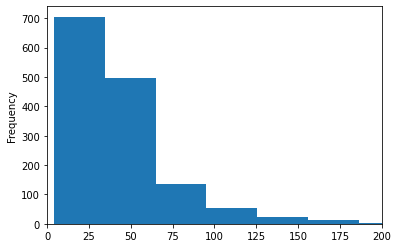

In [12]:
final_df.query("Actual_Sentiment == 1")["Review_len"].plot(kind="hist",xlim=(0,200))

In [13]:
import nlpaug.augmenter.word as naw
aug = naw.SynonymAug(aug_src="wordnet",aug_min=10) # Replace the words with their synonym.aug_min tells the no.of words to replace.

for i in aug.augment(final_df["Review"][1] , 3): # 3 represents the no,of augmented sentences we want to create.
    print(f"\n{i}\n")

/opt/conda/lib/python3.7/site-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '



As with all job, your experience testament depend greatly upon your manager. Ace had great, average and poor coach during my time there. I enjoyed the work and my coworkers. Their benefits bundle and employee perks be great.


As with all jobs, your experience will depend greatly upon your handler. 1 had great, fair and poor managers during my time there. I enjoyed the work and my coworkers. Their benefits package and employee perk are keen.


As with all jobs, your experience will depend greatly upon your manager. Ace had great, reasonable and poor managers during my time there. I enjoyed the work and my coworkers. Their benefits package and employee fringe benefit personify bang up.



In [14]:
def Augment_Review(df,augmenter=None,n_sentence=None,Sentiment=None):
    temp_df = df.query(f"Actual_Sentiment == {Sentiment}")
    temp_df.loc[:,"Review"] = temp_df.loc[:,"Review"].apply(lambda text : [result for result in augmenter.augment(text , n_sentence)])
    temp_df = temp_df.explode("Review")
    return temp_df
    
augmented_df = Augment_Review(final_df,augmenter=aug,n_sentence=5,Sentiment=1)
augmented_df = shuffle(augmented_df)
augmented_df.head()

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


,index,Review,Actual_Sentiment,Review_id,Review_len
3094,3094,fast pace private enterprise place to work. Fa...,1,3095,28
2488,2488,"Train on motorcar vary, depends mostly on the ...",1,2489,35
1534,1534,I learned everything on my ain. I really like ...,1,1535,45
508,508,Information technology a secure work place if ...,1,509,33
3983,3983,Domestic dog eat detent earthly concern. No ad...,1,3984,11


In [15]:
final_df = final_df.query('Actual_Sentiment == 0 or Actual_Sentiment == 2')
final_df = pd.concat([final_df,augmented_df] , axis=0,ignore_index=True)

final_df

,index,Review,Actual_Sentiment,Review_id,Review_len
0,0,1. This company has eight hours shift round th...,2,1,58
1,1,"As with all jobs, your experience will depend ...",2,2,38
2,2,Very hot and dirty working conditions very old...,2,3,30
3,3,Everyone is pretty helpful there especially be...,2,4,28
4,4,Rewarding place to work. Everyone is professio...,2,5,26
...,...,...,...,...,...
26591,5451,Company used to accept a groovy environs with ...,1,5452,43
26592,2300,I enjoyed the people I worked with very much. ...,1,2301,36
26593,2224,"jolly physically demanding work, just non so m...",1,2225,32
26594,4601,"Piece of work - life balance, Work - life bala...",1,4602,178


2    0.400323
0    0.327643
1    0.272033
Name: Actual_Sentiment, dtype: float64


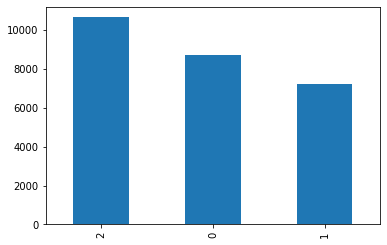

In [16]:
final_df["Actual_Sentiment"].value_counts().plot(kind="bar")
print(final_df["Actual_Sentiment"].value_counts(normalize=True))

# Now the dataset looks balanced to some extent.

In [17]:
PRE_TRAINED_MODEL_NAME = "bert-base-cased"
tokenizer = transformers.BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME) # BERT expect the tokens in a specific format,so we are using bert base model for it.

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [18]:
len(tokenizer.get_vocab()) # So this BERT model has a vocab size of 29k. and it cannnot be changed/appended.If BERT find a word that is not in the vocab,
#  it splits that words in the letters of different length and see if those splitted small words are present or not in the vocab .
# So every broken word(of the main word in our text) except the first one looks like "##letter". If even after splitting the words, BERT doesnt find any 
# matching token , it will assign it [UNK] token .

28996

In [19]:
print(tokenizer.sep_token)
print(tokenizer.sep_token_id)

[SEP]
102


In [20]:
tokens = tokenizer.tokenize(final_df["Review"][1])
print(tokens)
print(tokenizer.convert_tokens_to_ids(tokens))

['As', 'with', 'all', 'jobs', ',', 'your', 'experience', 'will', 'depend', 'greatly', 'upon', 'your', 'manager', '.', 'I', 'had', 'great', ',', 'fair', 'and', 'poor', 'managers', 'during', 'my', 'time', 'there', '.', 'I', 'enjoyed', 'the', 'work', 'and', 'my', 'cow', '##or', '##kers', '.', 'Their', 'benefits', 'package', 'and', 'employee', 'per', '##ks', 'are', 'great', '.']
[1249, 1114, 1155, 5448, 117, 1240, 2541, 1209, 12864, 5958, 1852, 1240, 2618, 119, 146, 1125, 1632, 117, 4652, 1105, 2869, 11493, 1219, 1139, 1159, 1175, 119, 146, 4927, 1103, 1250, 1105, 1139, 13991, 1766, 8811, 119, 2397, 6245, 7305, 1105, 7775, 1679, 4616, 1132, 1632, 119]


In [21]:
tokens = tokenizer.tokenize(final_df["Review"][274])
print(tokens)
print(tokenizer.convert_tokens_to_ids(tokens))

['John', 'Z', '##ink', 'Co', '##mb', '##ust', '##ion', 'is', 'one', 'of', 'the', 'greatest', 'companies', 'I', 'have', 'ever', 'worked', 'for', '.', 'Great', 'management', ',', 'training', ',', 'and', 'great', 'opportunities', 'for', 'advancement', '.', 'Would', 'highly', 'recommend', '.']
[1287, 163, 10223, 3291, 12913, 8954, 1988, 1110, 1141, 1104, 1103, 4459, 2557, 146, 1138, 1518, 1589, 1111, 119, 2038, 2635, 117, 2013, 117, 1105, 1632, 6305, 1111, 19024, 119, 5718, 3023, 18029, 119]


In [22]:
tokens = tokenizer.tokenize("Aditya is eating apple.")
print(tokens)
print(tokenizer.convert_tokens_to_ids(tokens))

['Ad', '##ity', '##a', 'is', 'eating', 'apple', '.']
[24930, 1785, 1161, 1110, 5497, 12075, 119]


In [23]:
tokens = tokenizer.tokenize("Aditya is planning to buy apple laptop.")
print(tokens)
print(tokenizer.convert_tokens_to_ids(tokens))

# Notice that apple has the same token id.

['Ad', '##ity', '##a', 'is', 'planning', 'to', 'buy', 'apple', 'laptop', '.']
[24930, 1785, 1161, 1110, 3693, 1106, 4417, 12075, 12574, 119]


In [24]:
"##ity" in tokenizer.get_vocab()

True

In [25]:
# max_length has to be decided based on the len of sentences we have in our corpus and is critical because we dont want lot of padding (0) and 
# also increasing max_length increases the training time.

encoding = tokenizer.encode_plus(final_df["Review"][1],max_length=100,add_special_tokens=True,padding='max_length',
                                 truncation=True,return_attention_mask=True,return_token_type_ids=False,return_tensors="pt")

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [26]:
encoding["input_ids"] # 0 means padded to make the tensor of constant length of max_length.
# We can notice that the tensor starts with 101 which is token id for [CLS] token telling BERT that this is a classification problem.
# We also have 102 in the end , which is token id for [SEP].

tensor([[  101,  1249,  1114,  1155,  5448,   117,  1240,  2541,  1209, 12864,
          5958,  1852,  1240,  2618,   119,   146,  1125,  1632,   117,  4652,
          1105,  2869, 11493,  1219,  1139,  1159,  1175,   119,   146,  4927,
          1103,  1250,  1105,  1139, 13991,  1766,  8811,   119,  2397,  6245,
          7305,  1105,  7775,  1679,  4616,  1132,  1632,   119,   102,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]])

In [27]:
encoding["attention_mask"] # It is 1 where actual tokens are there and 0 where padding is present.

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0]])

In [28]:
print(tokenizer.convert_ids_to_tokens(encoding["input_ids"][0]))

['[CLS]', 'As', 'with', 'all', 'jobs', ',', 'your', 'experience', 'will', 'depend', 'greatly', 'upon', 'your', 'manager', '.', 'I', 'had', 'great', ',', 'fair', 'and', 'poor', 'managers', 'during', 'my', 'time', 'there', '.', 'I', 'enjoyed', 'the', 'work', 'and', 'my', 'cow', '##or', '##kers', '.', 'Their', 'benefits', 'package', 'and', 'employee', 'per', '##ks', 'are', 'great', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


## Creating DataLoader using pytorch for BERT model

In [29]:
class ReviewDataset(data.Dataset):
    
    def __init__(self,reviews_text,targets,tokenizer,max_len):
        self.reviews_text = reviews_text # It is a numpy array of reviews text(what we get by using df["Review"].values).
#         So remember this an array of reviews and not a single review.
        self.targets = targets # Numpy array of targets i.e 1,2 and 3 in our case
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __len__(self):
        return self.reviews_text.shape[0]
    
    def __getitem__(self,idx):
        
        encoding = self.tokenizer.encode_plus(self.reviews_text[idx],max_length=self.max_len,add_special_tokens=True,truncation=True,
                                         padding='max_length',return_attention_mask=True,return_token_type_ids=False,return_tensors="pt")
        return {
            "review_text" : self.reviews_text[idx],
            "x" : encoding["input_ids"].flatten(),
            "y": torch.tensor(self.targets[idx],dtype=torch.long),
            "attention_mask": encoding['attention_mask'].flatten()
        }
    
# Note : All of these 3 above defined methods are compulsory for Dataset class to work.

In [30]:
df_train , df_test = train_test_split(final_df,test_size=0.3,random_state=101,stratify=final_df["Actual_Sentiment"])
df_val , df_test = train_test_split(df_test,test_size=0.5,random_state=101)

In [31]:
df_train.shape

(18617, 5)

In [32]:
print(df_train["Actual_Sentiment"].value_counts(normalize=True))
print(df_test["Actual_Sentiment"].value_counts(normalize=True))

2    0.400333
0    0.327658
1    0.272009
Name: Actual_Sentiment, dtype: float64
2    0.411779
0    0.319048
1    0.269173
Name: Actual_Sentiment, dtype: float64


In [33]:
def create_DataLoader(df,tokenizer,max_len,batch_size):
    
    dataset = ReviewDataset(reviews_text = df["Review"].to_numpy(),targets=df["Actual_Sentiment"].to_numpy(),
                       tokenizer=tokenizer,max_len=max_len)
    
    return data.DataLoader(dataset,batch_size=batch_size,num_workers=4) 
    

In [34]:
MAX_LEN = 100
BATCH_SIZE = 16 # No.of data input per step
EPOCHS = 4 # No.of times we want to train on all data.(step = epoch/batch_size)

In [35]:
train_DataLoader = create_DataLoader(df_train,tokenizer ,MAX_LEN, BATCH_SIZE)
test_DataLoader = create_DataLoader(df_test,tokenizer, MAX_LEN, BATCH_SIZE)
val_DataLoader = create_DataLoader(df_val,tokenizer, MAX_LEN, BATCH_SIZE)

In [36]:
train_DataLoader

In [37]:
for i in train_DataLoader:
    print(i)
    break
    
# If we see the below result,we have x,y and attention_mask as output in batch size=BATCH_SIZE and is in tensor format which is required by pytorch.
# Also note that y has 1,2 and 3 in the same ratio as we have in our dataset.So we can say our dataloader creation was correct and when we train our model,
# model will see reviews from all classes in each step and will not be bias towards a specific class.

{'review_text': ['Horrible management, the MBM philosophy they used was a joke. They bent it to their needs, not utilizing it as it was designed.', 'good pay and benefits plus avenues for growth. Many locations all over the US for transfer. Stable company. ', 'Koch bought GP in the spring of 2006. Immediately we all went through MBM Training . MBM teaches integrity, humility, respect, fulfillment, etc. Senior management does not practice this in my division. Commitment and dedication make no differerence whatsoever. I got a very raw deal in the end. If you are 50+, make a decent salary, and have 15+ years of seniority, you had better be looking for a job. No bonuses since the Koch acquisition. No raises since the Koch acquisition. ', 'Perform your job duties and report any findings to supervisor. Worked with good people, upper management was disconnected from management at the terminal level. Upper management preached working philosophy to us, but never practiced it themselves.', 'It w

In [38]:
for data in train_DataLoader:
    print(data['x'].shape)
    print(data["y"].shape)
    print(data["attention_mask"].shape)
    break

torch.Size([16, 100])
torch.Size([16])
torch.Size([16, 100])


## Building BERT Model

In [39]:
bert_model = transformers.BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [40]:
bert_model

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(28996, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [41]:
bert_model.config

BertConfig {
  "_name_or_path": "bert-base-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.6.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996
}

In [42]:
output = bert_model(input_ids = encoding["input_ids"] , attention_mask = encoding["attention_mask"])

In [43]:
print(output["last_hidden_state"].shape)
print(output["pooler_output"].shape)

#  You can think of the pooler_output as a summary of the content, according to BERT
#  768 is the number of hidden units in the feedforward-networks.

torch.Size([1, 100, 768])
torch.Size([1, 768])


In [44]:
class SentimentModel(nn.Module):
    
    def __init__(self,n_classes):
        super().__init__()
        
        self.bert_layer = transformers.BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME) # With this we have applied BERT embedding layer and 12 multi-head attention layers whose weights are already trained.
        
        self.dropout_layer = nn.Dropout(0.3) # Applying some regularization
        
        self.linear_layer = nn.Linear(self.bert_layer.config.hidden_size,n_classes)  # As output of BERT layer will be 1x768 ,so applying a Linear layer with input 768 and output as no.of classes,
#         to linearly transform this 1x768 vector into 1x3 (i.e our no.of classes)
                
        
    def forward(self,input_ids,attention_mask):
        
        output = self.bert_layer(input_ids=input_ids,attention_mask=attention_mask)
#         print(output['pooler_output'])
        output =  self.dropout_layer(output['pooler_output'])
#         print(output)
        output = self.linear_layer(output)
#         print(output)
        return output


# Note that we're returning the raw output of the last layer since that is required for the cross-entropy loss function in PyTorch to work.
# Later for predictions we need to use a softmax layer over this raw output to get the probabilities that adds upto 1.
        

In [45]:
model = SentimentModel(n_classes=3)
model(data["x"],data["attention_mask"])

# Note that the values over axis=1 doesnt add upto 1.

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tensor([[ 0.1790, -0.4156, -0.9835],
        [-0.6822, -0.6533, -0.5745],
        [-0.1200, -0.7411, -0.5536],
        [ 0.1799, -0.5515, -0.0570],
        [-0.3496, -0.4380, -0.6614],
        [ 0.1199, -0.5348, -0.3599],
        [-0.0201, -0.7936, -0.7021],
        [-0.1151, -0.3625, -0.8624],
        [-0.3032, -0.5352, -0.7781],
        [-0.5873,  0.1513, -0.7637],
        [-0.1135, -0.2401, -0.7415],
        [ 0.1238, -0.2173, -0.5030],
        [ 0.1734, -0.2817, -0.6842],
        [ 0.2601, -0.0464, -0.9371],
        [ 0.3035, -0.0213, -1.0365],
        [-0.3682, -0.9395, -0.5920]], grad_fn=<AddmmBackward>)

In [46]:
for name,value in model.named_parameters():
    print(name)

bert_layer.embeddings.word_embeddings.weight
bert_layer.embeddings.position_embeddings.weight
bert_layer.embeddings.token_type_embeddings.weight
bert_layer.embeddings.LayerNorm.weight
bert_layer.embeddings.LayerNorm.bias
bert_layer.encoder.layer.0.attention.self.query.weight
bert_layer.encoder.layer.0.attention.self.query.bias
bert_layer.encoder.layer.0.attention.self.key.weight
bert_layer.encoder.layer.0.attention.self.key.bias
bert_layer.encoder.layer.0.attention.self.value.weight
bert_layer.encoder.layer.0.attention.self.value.bias
bert_layer.encoder.layer.0.attention.output.dense.weight
bert_layer.encoder.layer.0.attention.output.dense.bias
bert_layer.encoder.layer.0.attention.output.LayerNorm.weight
bert_layer.encoder.layer.0.attention.output.LayerNorm.bias
bert_layer.encoder.layer.0.intermediate.dense.weight
bert_layer.encoder.layer.0.intermediate.dense.bias
bert_layer.encoder.layer.0.output.dense.weight
bert_layer.encoder.layer.0.output.dense.bias
bert_layer.encoder.layer.0.outp

In [47]:
for i in model.parameters():
    print(i)
    break

Parameter containing:
tensor([[-0.0005, -0.0416,  0.0131,  ..., -0.0039, -0.0335,  0.0150],
        [ 0.0169, -0.0311,  0.0042,  ..., -0.0147, -0.0356, -0.0036],
        [-0.0006, -0.0267,  0.0080,  ..., -0.0100, -0.0331, -0.0165],
        ...,
        [-0.0064,  0.0166, -0.0204,  ..., -0.0418, -0.0492,  0.0042],
        [-0.0048, -0.0027, -0.0290,  ..., -0.0512,  0.0045, -0.0118],
        [ 0.0313, -0.0297, -0.0230,  ..., -0.0145, -0.0525,  0.0284]],
       requires_grad=True)


## Training BERT model

In [48]:
model = model.to("cuda")

In [49]:
# Whatever model paramaters are provided in params will be updated every time we call optimizer.step().Here we are updating all our model parameters.

optimizer = transformers.AdamW(params=model.parameters() , lr=2e-5 , correct_bias=False)

total_steps = len(train_DataLoader) * EPOCHS

# Create a schedule with a learning rate that decreases linearly from the initial lr set in the optimizer to 0, after a warmup period during which it 
# increases linearly from 0 to the initial lr set in the optimizer
scheduler = transformers.get_linear_schedule_with_warmup(optimizer=optimizer , num_training_steps=total_steps, num_warmup_steps=0)

loss_function = nn.CrossEntropyLoss().to("cuda")

In [50]:
def train_one_step(model,optimizer,data,scheduler,loss_function):
    
    correct_prediction = 0
    
    optimizer.zero_grad() #Do this at starting of every step.Pytorch dont do it automatically as NN like RNN required gradients to add up over the iterations.
    
    data['x'] = data['x'].to("cuda")
    data['y'] = data['y'].to("cuda")
    data['attention_mask'] = data['attention_mask'].to("cuda")
        
    model_output = model(input_ids=data['x'],attention_mask=data['attention_mask'])
    
    _,pred = torch.max(model_output , dim=1) # This will return the max value and the position(0,1 or 2).
    
    loss = loss_function(model_output,data["y"]) # Input: (N, C)where C = number of classes.Check documentation.IMP
 
    loss.backward() # Calling .backward() mutiple times accumulates the gradient (by addition) for each parameter. This is why you should call optimizer.zero_grad() 
#     after each .step() call. Note that following the first .backward call, a second call is only possible after you have performed another forward pass.
    
    nn.utils.clip_grad_norm_(model.parameters() , max_norm=1.0) # Doing gradient cliping to avoid exploading gradient casses.
    
    optimizer.step()  # optimizer.step performs a parameter update based on the current gradient (stored in .grad attribute of a parameter) and the update rule
    
    correct_prediction += torch.sum(pred == data["y"])
    
    accuracy = correct_prediction/len(data['y'])

    return loss,accuracy
    

In [51]:
def train_one_epoch(model,data_loader,optimizer,scheduler,loss_function):
    
    model.train() # It doesnt train the model,but rather set a flag to let pytorch know that now model is in training phase.
#     This is done to make pytorch handle dropout differently during trainig and validation.
    total_loss = 0
    
    total_accuracy = 0
    
    for batch_index , data in enumerate(data_loader): # If total data in train set is 1000 and our batch_size is 10 so the below loop will run for 100 times/steps.
#         And in each step 10 data points will go as input.So train_one_step will get 10 data points at each iteration.
        
        loss , accuracy = train_one_step(model,optimizer,data,scheduler,loss_function)
        
        scheduler.step()
        
        total_loss += loss
        
        total_accuracy += accuracy
        
    return total_loss/len(data_loader) , total_accuracy/len(data_loader)

In [52]:
def val_one_step(model,data,loss_function):
    
    correct_prediction = 0
    
    data['x'] = data['x'].to("cuda")
    data['y'] = data['y'].to("cuda")
    data['attention_mask'] = data['attention_mask'].to("cuda")
        
    model_output = model(input_ids=data['x'],attention_mask=data['attention_mask'])
    
    _,pred = torch.max(model_output , dim=1) # This will return the max value and the position(0,1 or 2).
    
    loss = loss_function(model_output,data["y"])
    
    correct_prediction += torch.sum(pred == data["y"])
    
    accuracy = correct_prediction/len(data['y'])
    
    return loss , accuracy
    
    

In [53]:
def val_one_epoch(model,data_loader,loss_function):
    
    model.eval() # This dont evaluate the model but rather set some flag to make pytorch know that model 
#     is in evaluation phase now and so pytorch will handle drop out differently now.
    
    total_loss = 0
    
    total_accuracy = 0
    
    for batch_index ,data in enumerate(data_loader):
        
        with torch.no_grad(): # We dont want to update our parameters during validation.
            
            loss ,accuracy = val_one_step(model,data,loss_function)
            
        total_loss += loss
        
        total_accuracy += accuracy
        
    return total_loss/len(data_loader) , total_accuracy/len(data_loader)

In [54]:
history = defaultdict(list)

def train_model():
    
    global history
    best_accuracy = 0

    for epoch in range(EPOCHS):

        print(f"\nEpoch {epoch+1}/{EPOCHS}")
        print("-"*10)

        train_loss,train_accuracy = train_one_epoch(model,train_DataLoader,optimizer,scheduler,loss_function)
        print(f'Train Loss      : {train_loss:.4f} ,   Train Accuracy      : {train_accuracy:.4f}')

        val_loss,val_accuracy = val_one_epoch(model,val_DataLoader,loss_function)
        print(f'Validation Loss : {val_loss:.4f} ,   Validation Accuracy : {val_accuracy:.4f}')

        history["train_accuracy"].append(train_accuracy)
        history["val_accuracy"].append(val_accuracy)
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)

        if val_accuracy > best_accuracy:
            torch.save(model.state_dict(),f"best_model_{epoch}.bin") # In PyTorch, the learnable parameters (i.e. weights and biases) of a torch.nn.Module model are 
#             contained in the model’s parameters (accessed with model.parameters()). A state_dict is simply a Python dictionary object that maps each layer to its parameter tensor.
# A state_dict is an integral entity if you are interested in saving or loading models from PyTorch. Because state_dict objects are Python dictionaries, they can be easily saved, 
# updated, altered, and restored, adding a great deal of modularity to PyTorch models and optimizers
            best_accuracy = val_accuracy
            
    return best_accuracy

In [55]:
%%time

# train_model()

# As the model's validation loss keeps on increasing after the first epoch,our model is overfitting,
# so we will use the model build after the first epoch only.


Epoch 1/4
----------
Train Loss      : 0.3493 ,   Train Accuracy      : 0.8724
Validation Loss : 0.2667 ,   Valiadtion Accuracy : 0.9043

Epoch 2/4
----------
Train Loss      : 0.1553 ,   Train Accuracy      : 0.9548
Validation Loss : 0.3265 ,   Valiadtion Accuracy : 0.9133

Epoch 3/4
----------
Train Loss      : 0.0876 ,   Train Accuracy      : 0.9791
Validation Loss : 0.3849 ,   Valiadtion Accuracy : 0.9132

Epoch 4/4
----------
Train Loss      : 0.0604 ,   Train Accuracy      : 0.9863
Validation Loss : 0.4278 ,   Valiadtion Accuracy : 0.9105
CPU times: user 15min 32s, sys: 8.45 s, total: 15min 41s
Wall time: 16min 1s


tensor(0.9133, device='cuda:0')

## Loading the Saved Model

In [60]:
final_model = SentimentModel(3)
final_model.load_state_dict(torch.load('../input/trained-model/best_model_0.bin'))
final_model

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


SentimentModel(
  (bert_layer): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affi

In [74]:
def predict(model,data_loader):
    
    model.eval()
    
    reviews_text = []
    predictions = []
    actuals = []
    pred_probabilities = []
    
    with torch.no_grad():
        
        for data in data_loader:
            
            data['x'] = data['x'].cuda()
            data['y'] = data['y'].cuda()
            data['attention_mask'] = data['attention_mask'].cuda()
        
            model_output = model(input_ids = data['x'] , attention_mask = data['attention_mask'])

            _,pred = torch.max(model_output , dim=1) # This will return the max value and the position(0,1 or 2).
            
            pred_proba = nn.functional.softmax(model_output , dim=1) # Because model output is just after a linear layer.We want to compress it btw 0 and 1.
            
            predictions.extend(pred)
            actuals.extend(data['y'])
            reviews_text.extend(data['review_text'])
            pred_probabilities.extend(pred_proba)
        
        # Converting in tensors using stack method and putting into CPU
        return reviews_text,torch.stack(predictions).cpu(),torch.stack(actuals).cpu(),torch.stack(pred_probabilities).cpu()
    

In [75]:
reviews,predicted,actuals,pred_proba = predict(model,test_DataLoader)

In [94]:
accuracy = accuracy_score(actuals,predicted)
mathews_coeff = matthews_corrcoef(actuals,predicted)
confusion = confusion_matrix(actuals,predicted)
class_report = classification_report(actuals,predicted)

print(f"Accuracy               : {accuracy:.3f}")
print(f"\nMatthews_Corr_coef     : {mathews_coeff:.3f}")
print(f'\n{class_report}')

Accuracy               : 0.923

Matthews_Corr_coef     : 0.882

              precision    recall  f1-score   support

           0       0.90      0.89      0.90      1273
           1       0.99      0.96      0.97      1074
           2       0.90      0.93      0.91      1643

    accuracy                           0.92      3990
   macro avg       0.93      0.92      0.93      3990
weighted avg       0.92      0.92      0.92      3990



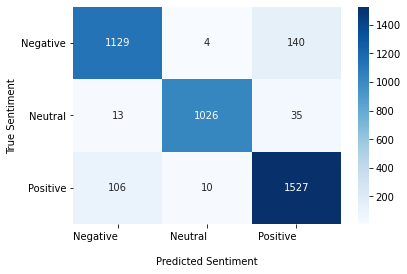

In [99]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=0, ha='right')
  plt.ylabel('True Sentiment')
  plt.xlabel('\nPredicted Sentiment');

df_cm = pd.DataFrame(confusion, index=["Negative","Neutral","Positive"], columns=["Negative","Neutral","Positive"])
show_confusion_matrix(df_cm)